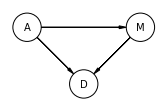
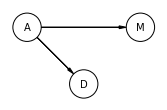


if we regress the divorce outcome  on M and A independently both models will find a relation.

In the second dag if look at only tow terms (M,D)) we should see a realtion between M and D because they share the same cause but one is not the cause of another.
 


In [7]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata
from theano import shared

ModuleNotFoundError: No module named 'daft'

In [2]:
data = pd.read_csv("data/WaffleDivorce.csv",sep=';', header=0)

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

<h3> Model I: Divorce vs Marriageage</h3>


In [4]:
with pm.Model() as medianage:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_medianage = pm.sample_prior_predictive()
    
    medianage_trace = pm.sample()
    posteriorpredictive_medianage=pm.sample_posterior_predictive(medianage_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
100%|██████████| 1000/1000 [00:04<00:00, 210.81it/s]


In [5]:
%matplotlib inline

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


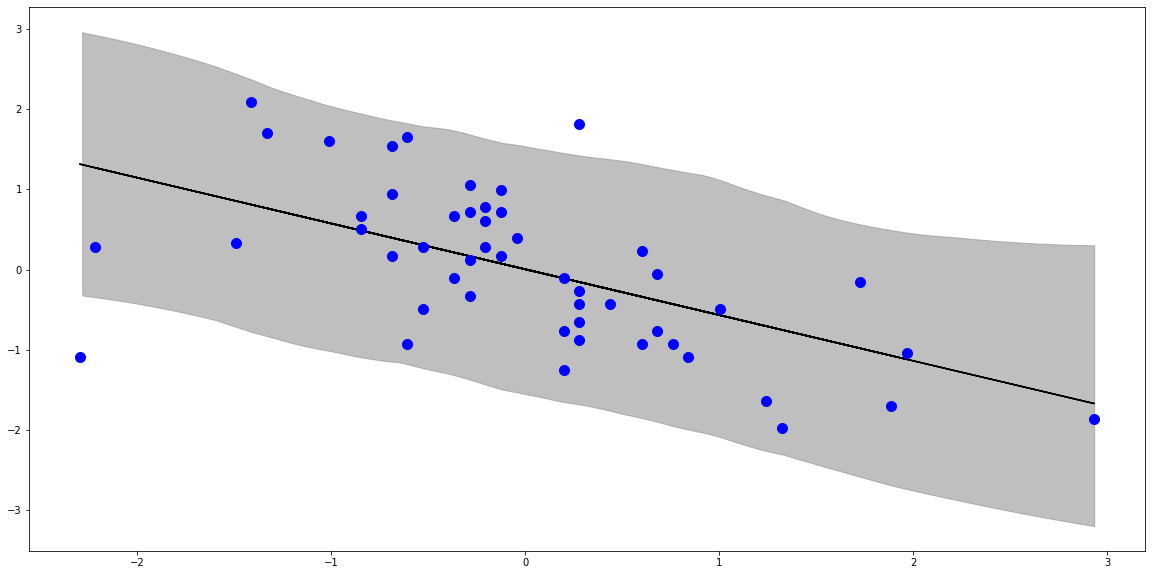

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
az.plot_hdi(data["MedianAgeMarriage_std"],    posteriorpredictive_medianage["divorce_rate_std"], credible_interval=0.94, color='gray', ax=ax)
plt.plot(data["MedianAgeMarriage_std"],  medianage_trace ["a"].mean() +  medianage_trace ["bA"].mean() * (data["MedianAgeMarriage_std"]),color="black")
plt.plot(data["MedianAgeMarriage_std"],data["Divorce_std"], 'b.', markersize=20)
#plt.plot(df2.weight, tracedeterminist["alpha"].mean() + tracedeterminist["beta"].mean() * (df2.weight_c),color="black")
#plt.plot(df2.weight, df2.height, 'b.', markersize=20)

In [7]:
medianage_trace["bA"].mean()

-0.5651243170912463

<h3>MODEL II: Divorce versus Mariagerate</h3>

In [7]:
with pm.Model() as marriage:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples_marriage = pm.sample_prior_predictive()
    marriage_trace = pm.sample()
    posteriorpredictive_mariage=pm.sample_posterior_predictive(  marriage_trace)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]
100%|██████████| 1000/1000 [00:05<00:00, 171.93it/s]


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


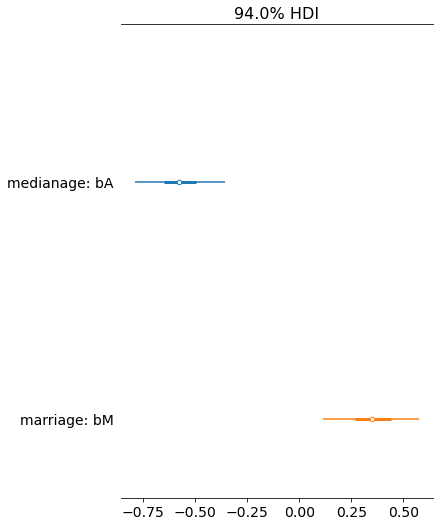

In [8]:
az.plot_forest(
    [medianage_trace, marriage_trace],
    model_names=["medianage", "marriage"],
    var_names=["bA", "bM"],
    combined=True,
);


Let's consider the <b>second dag</b> .In this DAG, it is still true that all three variable are associated with one another. A is associated with D and M because it influences them both.

And D and M are associated with one another, because A influences them both. They share a cause, and this leads them to be correlated with one another through that cause.

<b>But suppose we condition on A. All of the information in M that is relevant to predicting D is in A. So once we’ve conditioned on A, M should tell us nothing more about D.</b>

So in the second DAG, a testable implication is that D is independent of M, conditional on A. In other words, D ⊥⊥ M|A. The same thing does not happen with the first DAG. Conditioning on A does not make D independent of M, because M really influences D all by itself in this model.

[('D', 'M', {'A'})]  or D ⊥⊥ M|A.

<h3> MODEL III: D versus age and mariage rate </h3>
<p>
    multiple regression can address a useful descriptive question:

Is there any additional value in knowing a variable, once I already know all of the other predictor variables?

So for example once you fit a multiple regression to predict divorce using both marriage rate and age at marriage, the model addresses the questions:

(1) After I already know marriage rate, what additional value is there in also knowing age at marriage (bA)?

(2) After I already know age at marriage, what additional value is there in also knowing marriage rate bM?
</p>    



In [9]:
with pm.Model() as multregdiv:
    # M->D<-A 
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"] + bA * data["MedianAgeMarriage_std"]
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_multi= pm.sample_prior_predictive()
    multregdiv_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:25<00:00, 78.49draws/s] 


In [15]:
az.summary(multregdiv_trace, var_names=["a", "bM", "bA", "sigma"])

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.097,-0.182,0.168,0.004,0.003,755.0,490.0,749.0,704.0,1.00
bM,-0.062,0.152,-0.353,0.215,0.006,0.005,618.0,471.0,653.0,506.0,1.01
bA,-0.608,0.154,-0.879,-0.308,0.005,0.004,817.0,817.0,816.0,571.0,1.00
sigma,0.826,0.083,0.683,0.979,0.003,0.002,723.0,707.0,750.0,660.0,1.01


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


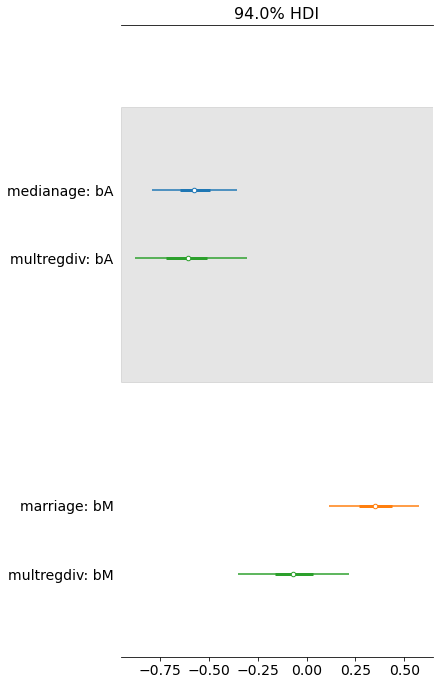

In [16]:
az.plot_forest(
    [medianage_trace, marriage_trace,multregdiv_trace],
    model_names=["medianage", "marriage","multregdiv"],
    var_names=["bA", "bM"],
    combined=True,
);


Notice how bA doesn’t move, only grows a bit more uncertain, while bM is only associated with divorce when age at marriage is missing from the model. You can interpret these distributions as saying:

Once we know median age at marriage for a State, there is little or no additional predictive power in also knowing the rate of marriage in that State.


We can also state the description as Divorce is independent of M if we conditon it on A. Hence the second dag.

<h3>Draing dags and getting dependicies of dag  </h3>



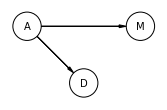

In [10]:
# Note - There is no explicit code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

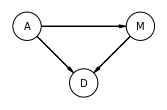

In [11]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [13]:
dag5_2.get_all_independence_relationships()

[('M', 'D', {'A'})]

In [14]:
dag5_1.get_all_independence_relationships()

[]

<h1>Plotting multivariate posteriors</h1>

<h2>  a) posterior predictive plots </h2>

<p>(1) Did the model correctly approximate the posterior distribution? 
Errors can be more easily diagnosed by comparing implied predictions to the raw data. 
Some caution is required, because not all
models try to exactly match the sample. But even then, you’ll know what to expect
from a successful approximation. 


(2) How does the model fail? All models are useful fictions, so they always fail in some
way. Sometimes, the model fits correctly but is still so poor for our purposes that
it must be discarded. More often, a model predicts well in some respects, but not
in others. By inspecting the individual cases where the model makes poor predictions,
you might get an idea of how to improve the model. The difficulty is that this
process is essentially creative and relies upon the analysts domain expertise. It also risks chasing noise.</p>

In [18]:
with multregdiv:
     m_5_3_ppc = pm.sample_posterior_predictive(
    multregdiv_trace, var_names=["mu", "divorce_rate_std"], samples=1000
    )

100%|██████████| 1000/1000 [00:07<00:00, 140.62it/s]


In [19]:
mu_mean = m_5_3_ppc["mu"].mean(axis=0)
mu_hpd = az.hdi(m_5_3_ppc["mu"], 0.89)

D_sim = m_5_3_ppc["divorce_rate_std"].mean(axis=0)
D_PI = az.hdi(m_5_3_ppc["divorce_rate_std"], 0.89)

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


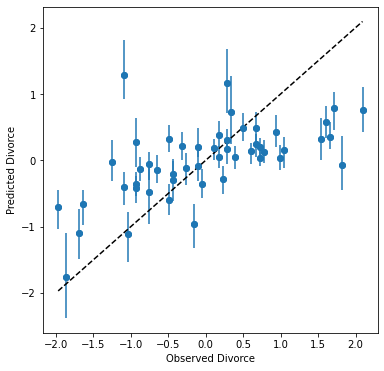

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    m_5_3_ppc["divorce_rate_std"].mean(0),
    yerr=np.abs(m_5_3_ppc["divorce_rate_std"].mean(0) - mu_hpd.T),
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");
#plt.savefig('out1.png')

It’s easy to see from this arrangement of the simulations
that the model under-predicts for States with very high divorce rates while it overpredicts
for States with very low divorce rates.That’s normal. This is what regression does—it
is skeptical of extreme values, so it expects regression towards the mean. But beyond this general
regression to the mean, some States are very frustrating to the model, lying very far from
the diagonal. I’ve labeled some points like this, including Idaho (ID) and Utah (UT), both of which have much lower divorce rates than the model expects them to have.


<h2>  b) counterfactaual plots </h2>

<h1>Masked relationship</h1>


The divorce rate example demonstrates that multiple predictor variables are useful for
knocking out spurious association.

A second reason to use more than one predictor variable
is to measure the direct influences of multiple factors on an outcome, when none of those
influences is apparent from bivariate relationships.

This kind of problem tends to arise when
there are two predictor variables that are correlated with one another.
However, one of these
is positively correlated with the outcome and the other is negatively correlated with it.

You’ll consider this kind of problem in a new data context, information about the composition
of milk across primate species, as well as some facts about those species, like body
mass and brain size.

Milk is a huge investment, being much more expensive than gestation.
Such an expensive resource is likely adjusted in subtle ways, depending upon the physiological
and development details of each mammal species.
The question here is to what extent energy content of milk, measured here by kilocalories, is related to the percent of the brain mass that is neocortex. Neocortex is the gray, outer part of the brain that is particularly elaborated in mammals and especially primates. We’ll end up needing female body mass as well, to see the masking that hides the relationships among the variables. Let’s standardize these three variables. As in previous examples, standardizing helps us both get a reliable approximation of the posterior as well as build reasonable priors.


In [52]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()



,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


The first model to consider is the simple bivariate regression between kilocalories and
neocortex percent. In mathematical form:


K<sub>i</sub> ∼ Normal(μ<sub>i</sub>, σ)

μi = α + β<sub>N</sub>N<sub>i</sub>

where K is standardized kilocalories and N is standardized neocortex percent. We still need
to consider the priors. But first let’s just try to run this  model with some vague
priors, because there is another key modeling issue to address first.

In [53]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

In [10]:
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * d["N"])

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains, 0 divergences:   0%|          | 0/2000 [00:04<?, ?draws/s]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
K   NaN


ParallelSamplingError: Bad initial energy

In [11]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

In [54]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

In [55]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_draft_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:08<00:00, 235.39draws/s]


In [30]:
shared_N.get_value()

array([-2.08019603, -0.50864129, -0.50864129,  0.01074247,  0.21346968,
       -1.46196181, -0.98613926, -1.21567338,  0.40111801,  0.47483699,
        0.97579101, -0.00768727,  0.61724867,  0.84175649,  0.44635466,
        1.46166614,  1.32595619])

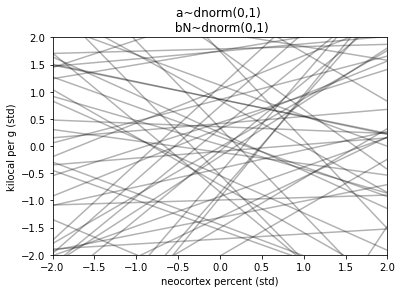

In [56]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq, m5_5_draft_prior_predictive["K"][i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

I’ve shown a range of 2 standard deviations for both variables. So that is most of the outcome space. These lines are crazy. As in previous examples, we can do better by both tightening the α prior so that it sticks closer to zero. With two standardized variables, when predictor is zero, the expected value of the outcome should also be zero. And the slope βN needs to be a bit tighter as well, so that it doesn’t regularly produce impossibly strong relationships. Here’s an attempt:

In [57]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_trace = pm.sample()

m5_5_data = az.from_pymc3(m5_5_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:07<00:00, 258.71draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [58]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.043,0.164,-0.242,0.351,0.005,0.004,1071.0,705.0,1059.0,715.0,1.01
bN,0.129,0.263,-0.370,0.588,0.007,0.008,1440.0,554.0,1454.0,566.0,1.00
sigma,1.115,0.200,0.770,1.492,0.007,0.005,917.0,882.0,950.0,627.0,1.00


From this summary, you can possibly see that this is neither a strong nor very precise association.
The standard deviation is almost twice the posterior mean. But as always, it’s much
easier to see this if we draw a picture. e can plot the predicted mean and compatibility interval for the mean to see
this more easily:

100%|██████████| 4000/4000 [00:02<00:00, 1434.37it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


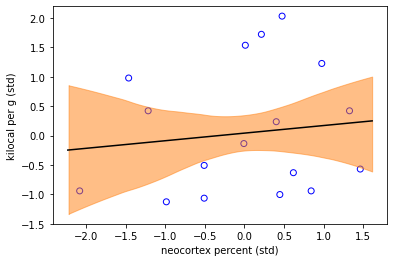

In [59]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(
        m5_5_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_5_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hpd(xseq, m5_5_posterior_predictive["mu"], ax=ax)
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

Now consider another predictor variable, adult female body mass, mass in the data
frame. 
Now we construct a similar model, but consider the bivariate relationship between kilocalories
and body mass:

In [60]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample()

m5_6_data = az.from_pymc3(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:09<00:00, 216.05draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.299,0.239,-0.737,0.131,0.008,0.005,996.0,996.0,1026.0,562.0,1.0
a,0.050,0.156,-0.238,0.341,0.005,0.004,1025.0,625.0,1021.0,672.0,1.0
sigma,1.051,0.191,0.748,1.426,0.006,0.004,1033.0,995.0,1021.0,621.0,1.0


100%|██████████| 4000/4000 [00:02<00:00, 1379.58it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


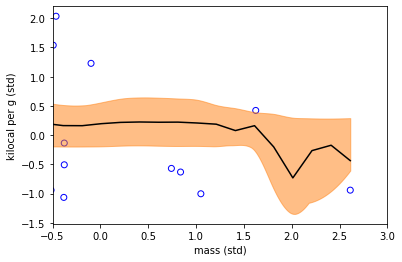

In [61]:
xseq = np.linspace(dcc["M"].min() , dcc["M"].max() , 17)

shared_N.set_value(xseq)


with m5_6:
    m5_6_posterior_predictive = pm.sample_posterior_predictive(
         m5_6_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_6_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["M"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hpd(xseq, m5_6_posterior_predictive["mu"], ax=ax)
ax.set_xlim(-0.5, 3)
ax.set_xlabel("mass (std)")
ax.set_ylabel("kilocal per g (std)");

It is often true that scaling measurements like
body mass are related by magnitudes to other variables. Taking the log of a measure translates
the measure into magnitudes. So by using the logarithm of body mass here, we’re saying
that we suspect that the magnitude of a mother’s body mass is related to milk energy, in a
linear fashion.
Now we construct a similar model, but consider the bivariate relationship between kilocalories
and body mass:

In [62]:
dcc['log_mass'] = np.log(dcc['mass'])
shared_M = shared(dcc["log_mass"].values)

with pm.Model() as m5_6p:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6p_trace = pm.sample()

m5_6p_data = az.from_pymc3(m5_6_trace)
az.summary(m5_6p_trace, var_names=["bM", "a", "sigma"])

<ipython-input-62-e82c27ce886e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcc['log_mass'] = np.log(dcc['mass'])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:08<00:00, 231.88draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.115,0.123,-0.332,0.117,0.005,0.004,698.0,583.0,708.0,692.0,1.00
a,0.099,0.170,-0.220,0.401,0.006,0.005,704.0,597.0,707.0,661.0,1.01
sigma,1.095,0.216,0.736,1.489,0.009,0.007,560.0,511.0,644.0,506.0,1.00


100%|██████████| 4000/4000 [00:03<00:00, 1101.64it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


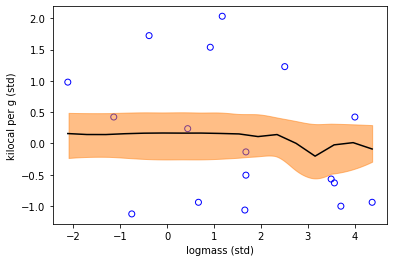

In [63]:
xseq = np.linspace(dcc["log_mass"].min() , dcc["log_mass"].max() , 17)

shared_N.set_value(xseq)

with m5_6:
    m5_6p_posterior_predictive = pm.sample_posterior_predictive(
         m5_6p_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_6p_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["log_mass"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hpd(xseq, m5_6p_posterior_predictive["mu"], ax=ax)
#ax.set_xlim(-0.5, 3)
ax.set_xlabel("logmass (std)")
ax.set_ylabel("kilocal per g (std)");

Now let’s see what happens when we add both predictor variables at the same time to the regression. This is the multivariate model, in math form: Ki ∼ Normal(μi, σ) μi = α + βNNi + βMMi α ∼ Normal(0, 0.2) βn ∼ Normal(0, 0.5) βm ∼ Normal(0, 0.5) σ ∼ Exponential(1)


In [64]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["log_mass"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample(tune=2000, draws=10000)

m5_7_data = az.from_pymc3(m5_7_trace)
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, bN, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 24000/24000 [00:53<00:00, 446.08draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.194,0.183,-0.145,0.537,0.002,0.001,9374.0,9374.0,9385.0,11315.0,1.0
bN,0.405,0.278,-0.125,0.918,0.003,0.002,9485.0,9485.0,9515.0,12327.0,1.0
bM,-0.231,0.134,-0.473,0.029,0.001,0.001,8553.0,8553.0,8513.0,11564.0,1.0
sigma,0.987,0.202,0.637,1.360,0.002,0.001,10132.0,10132.0,9909.0,10742.0,1.0


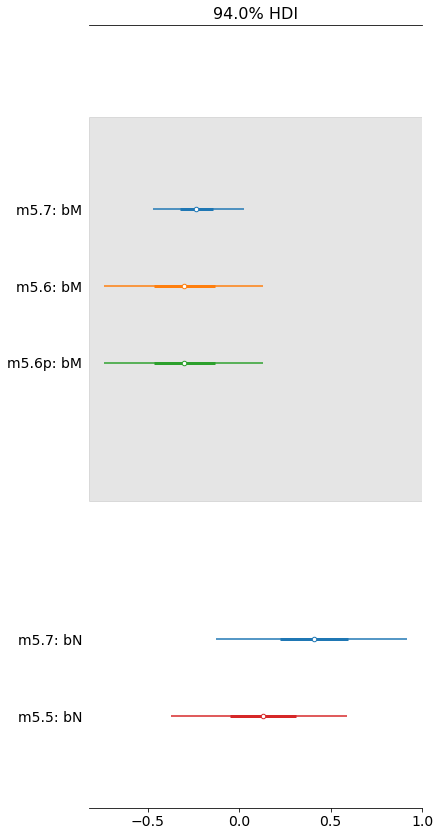

In [65]:
  az.plot_forest(
    [m5_7_data, m5_6_data,m5_6p_data, m5_5_data],
    model_names=["m5.7", "m5.6","m5.6p", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
);

The posterior mean for the association of neocortex percent has increased fivefold, and its
89% interval is now entirely above zero. The posterior mean for log body mass has increased
2.5 times in magnitude.


This is a context in which there are two variables
correlated with the outcome, but one is positively correlated with it and the other is negatively
correlated with it. 

In addition, both of the explanatory variables are positively correlated with
one another. 

 As a result, they tend to cancel one another out.
 
 
This is another case in which multiple regression automatically finds the most revealing
cases and uses them to produce inferences. 

What the regression model does is ask if species
that have high neocortex percent for their body mass have higher milk energy. Likewise, the
model asks if species with high body mass for their neocortex percent have higher milk energy.


Bigger species, like apes, have milk with less energy. But species with more neocortex tend
to have richer milk. 
The fact that these two variables, body size and neocortex, are correlated
across species makes it hard to see these relationships, unless we account for both.


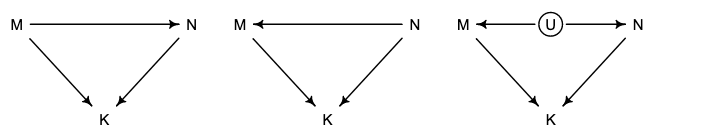


Which of these graphs is right? We can’t tell from the data alone, because these graphs
imply the same set of conditional independencies. In this case, there are no conditional
independencies—each DAG above implies that all pairs of variables are associated, regardless
of what we condition on. A set of DAGs with the same conditional independencies is known
as a Markov equivalence set.Remember that while the data alone can never tell you which causal model
is correct, your scientific knowledge of the variables will eliminate a large number of silly, but
Markov equivalent, DAGs.

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 4000/4000 [00:06<00:00, 639.03it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


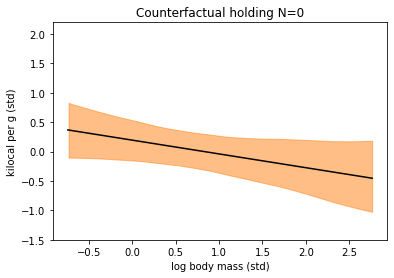

In [66]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(
        m5_7_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_7_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
az.plot_hpd(xseq, m5_7_posterior_predictive["mu"], ax=ax)

ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");

<h1> Categorical Values </h1>

A common question for statistical methods is to what extent an outcome changes as a
result of presence or absence of a category. A category here means discrete and unordered.
For example, consider the different species in the milk energy data again. Some of them are
apes, while others are New World monkeys. We might want to ask how predictions should
vary when the species is an ape instead of a monkey. Taxonomic group is a categorical
variable, because no species can be half-ape and half-monkey (discreteness), and there
is no sense in which one is larger or smaller than the other (unordered). Other common
examples of categorical variables include:
• Sex: male, female
• Developmental status: infant, juvenile, adult
• Geographic region: Africa, Europe, Melanesia


In [69]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")


In [72]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

In [71]:
d


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade_id
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,3
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,3
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,3
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,3
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,3
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,1
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,1
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN,1
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:16<00:00, 121.95draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


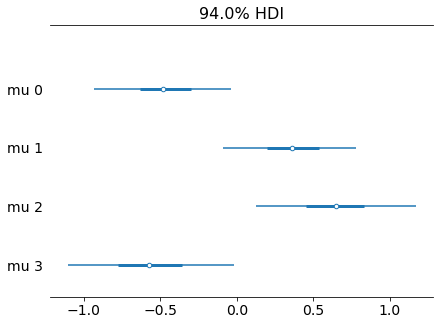

In [73]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=d["clade_id"].max() + 1)
    K = pm.Normal("K", mu[d["clade_id"]], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"]);

<h1>Multi collinearity</h1>

It is commonly true that there are many potential predictor variables to add to a regression
model. In the case of the primate milk data, for example, there are 7 variables available
to predict any column we choose as an outcome. Why not just fit a model that includes all
7? There are several hazards. The one we’ll focus on here is multicollinearity. Multicollinearity
means very strong correlation between two or more predictor variables. The
consequence of it is that the posterior distribution will seem to suggest that none of the variables
is reliably associated with the outcome, even if all of the variables are in reality strongly
associated with the outcome. This frustrating phenomenon arises from the details of how
multiple regression works. In fact, there is nothing wrong with multicollinearity. The model
will work fine for prediction. You will just be frustrated trying to understand it. The hope is
that once you understand multicollinearity, you will better understand regression models in
general.

In [5]:
import numpy as np
import pandas as pd
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

,height,leg_left,leg_right
0,13.285234,6.013696,6.051481
1,12.792915,5.659335,5.618286
2,11.682032,5.798847,5.800034
3,12.233707,5.540942,5.533621
4,8.627411,3.771335,3.718801


In [ ]:

with pm.Model() as m_6_1:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)

    mu = a + bl * d.leg_left + br * d.leg_right
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)

    m_6_1_trace = pm.sample()
    idata_6_1 = az.from_pymc3(m_6_1_trace)  # create an arviz InferenceData object from the trace.
    # this happens automatically when calling az.summary, but as we'll be using this trace multiple
    # times below it's more efficient to do the conversion once at the start.

az.summary(idata_6_1, round_to=2)

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['mu'] have not been found and will be ignored
  warnings.warn(


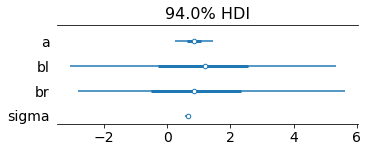

In [77]:
_ = az.plot_forest(m_6_1_trace, var_names=["~mu"], combined=True, figsize=[5, 2])

In [78]:
with pm.Model() as m_6_2:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)

    mu = a + bl * d.leg_left
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)

    m_6_2_trace = pm.sample()
    idata_m_6_2 = az.from_pymc3(m_6_2_trace)

az.summary(idata_m_6_2, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:20<00:00, 98.72draws/s] 


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.85,0.33,0.21,1.44,0.02,0.01,323.27,323.27,319.44,338.67,1.01
bl,2.02,0.07,1.88,2.15,0.00,0.00,318.38,317.40,319.81,415.01,1.01
sigma,0.65,0.05,0.56,0.74,0.00,0.00,440.07,422.54,460.29,249.44,1.01
